Analyze 19/5-9 neq switching

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    d_dgs_phase['solvent'] = (solvent_dg, solvent_ddg)
    
    return d_dgs_phase
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
    # Substract offset
    print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()
    

## ALA->VAL

In [3]:
# Load data into dicts and plot 
titles = ["ALA->VAL"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 5
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 5
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/5/5_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/5/5_apo_work_dist.png
-27.235691919724687 0.16340113550635912


<Figure size 432x288 with 0 Axes>

(array([ 2.,  6.,  5., 13., 17., 21., 17., 13.,  4.,  2.]),
 array([-138.05081577, -118.23056735,  -98.41031893,  -78.5900705 ,
         -58.76982208,  -38.94957366,  -19.12932523,    0.69092319,
          20.51117161,   40.33142003,   60.15166846]),
 <BarContainer object of 10 artists>)

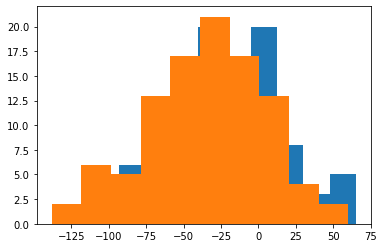

In [4]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[-16.12, (-19.06, -13.08)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

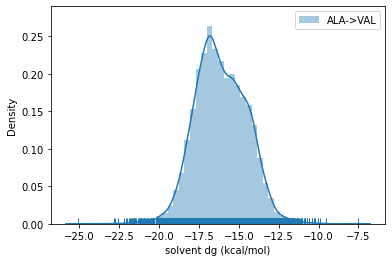

In [10]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->THR

In [11]:
# Load data into dicts and plot 
titles = ["ALA->THR"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 6
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 6
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/6/6_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/6/6_apo_work_dist.png
-51.63867339055901 0.13461212621233082


<Figure size 432x288 with 0 Axes>

(array([ 2.,  2.,  6., 15., 18., 16., 24., 15.,  1.,  1.]),
 array([-212.45522378, -182.76183688, -153.06844998, -123.37506308,
         -93.68167618,  -63.98828928,  -34.29490238,   -4.60151548,
          25.09187142,   54.78525832,   84.47864522]),
 <BarContainer object of 10 artists>)

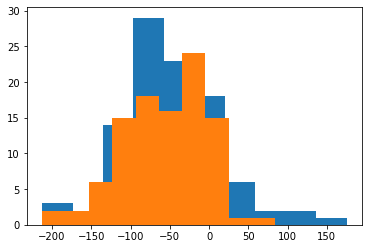

In [12]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [13]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [15]:
output_kcalmol

[-30.78, (-37.68, -24.01)]

In [16]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [17]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

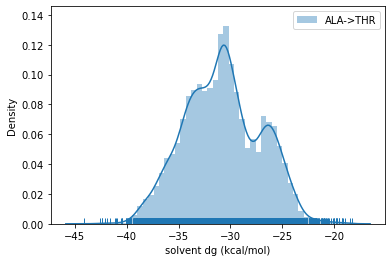

In [18]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->TYR

In [19]:
# Load data into dicts and plot 
titles = ["ALA->LYS"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 7
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 7
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/7/7_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/7/7_apo_work_dist.png
-19.083344270376188 0.1392330626496044


<Figure size 432x288 with 0 Axes>

(array([ 1.,  7.,  3., 12., 13., 28., 22.,  7.,  5.,  2.]),
 array([-171.93295358, -144.08560697, -116.23826035,  -88.39091373,
         -60.54356711,  -32.69622049,   -4.84887387,   22.99847275,
          50.84581937,   78.69316598,  106.5405126 ]),
 <BarContainer object of 10 artists>)

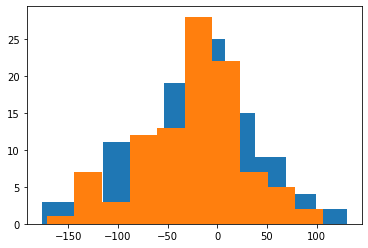

In [20]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [21]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [23]:
output_kcalmol

[-11.14, (-14.45, -6.51)]

In [24]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [25]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

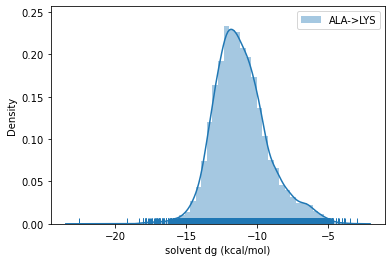

In [26]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->ASP

In [27]:
# Load data into dicts and plot 
titles = ["ALA->ASP"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 8
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 8
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/8/8_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/8/8_apo_work_dist.png
-276.4063937242772 0.12602769563411012


<Figure size 432x288 with 0 Axes>

(array([ 4., 10., 16., 13., 28., 17.,  5.,  4.,  2.,  1.]),
 array([-466.14140707, -419.25328076, -372.36515446, -325.47702815,
        -278.58890184, -231.70077554, -184.81264923, -137.92452292,
         -91.03639661,  -44.14827031,    2.739856  ]),
 <BarContainer object of 10 artists>)

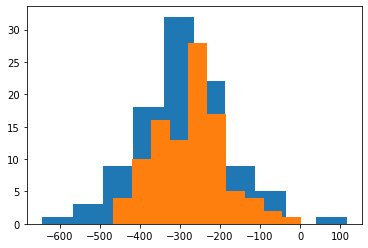

In [28]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [29]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [31]:
output_kcalmol

[-165.13, (-173.02, -158.45)]

In [32]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [33]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

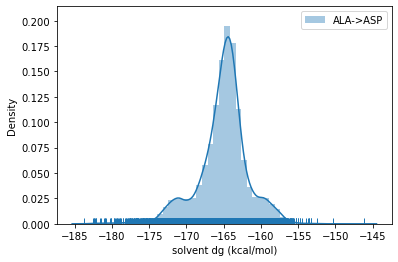

In [34]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()

## ALA->LYS

In [35]:
# Load data into dicts and plot 
titles = ["ALA->LYS"]
phases = ['solvent']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 19
forward = 9
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"solvent":{}}
    d_combined_works = {"solvent":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated
    
    d_input[i] = d_works
    
    # Plot
    solvent_dg, solvent_ddg = analyze(d_works['solvent']['forward'], d_works['solvent']['reverse'])
    plot(d_combined_works['solvent']['forward'], d_combined_works['solvent']['reverse'], solvent_dg, solvent_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print(solvent_dg, solvent_ddg)

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 9
100
100
subtracting offset
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/9/9_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/19/9/9_apo_work_dist.png
-154.39562936013192 0.1444387378775232


<Figure size 432x288 with 0 Axes>

(array([ 1.,  2.,  6., 14., 24., 23., 17.,  8.,  2.,  3.]),
 array([-286.41338013, -261.45285102, -236.49232192, -211.53179281,
        -186.57126371, -161.6107346 , -136.65020549, -111.68967639,
         -86.72914728,  -61.76861817,  -36.80808907]),
 <BarContainer object of 10 artists>)

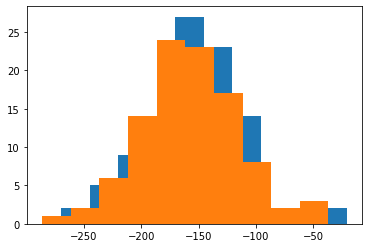

In [36]:
plt.hist(d_works['solvent']['forward'])
plt.hist(d_works['solvent']['reverse']*-1)

In [37]:
# Bootstrap works
N_bootstraps = 10000
phases = ['solvent']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"solvent": {"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
    dgs_phase[i] = dgs_phase_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [38]:
dgs = [d['solvent'][0] for d in dgs_phase[forward]]
solvent_dg = np.mean(dgs)
forward_ci = np.percentile(dgs, 2.5), np.percentile(dgs, 97.5)

output_kcalmol = [round(solvent_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [39]:
output_kcalmol

[-92.2, (-96.28, -88.67)]

In [40]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [41]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)

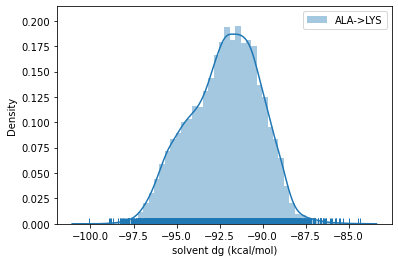

In [42]:
# Plot ddgs
sns.distplot(np.array(dgs)*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("solvent dg (kcal/mol)")
plt.legend()